In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
import json
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Load Data

In [2]:
def load_data():
    league_data_dir = os.getcwd() + '/data/leaguedata'
    all_data = []
    for _, _, filenames in os.walk('/kaggle/input'):
        for filename in filenames:
            if not filename.startswith("20"):
                continue
            league = "Premier League" if "PremierLeague" in filename else "La Liga" if "LaLiga" in filename else "Bundesliga" if "Bundesliga" in filename else "SerieA" if "SerieA" in filename else "Ligue1"
            year = 2017 if "2017" in filename else 2018 if "2018" in filename else 2019 if "2019" in filename else "2020"
            f = open(f'../input/top5legauesplayers-statsandphys/Football_Players/{filename}', 'r')
            for line in f:
                data = json.loads(line)
                merged_dict = {
                    'name': data['name'] if 'name' in data else None, 
                    'age': data['age'] if 'age' in data else None, 
                    'nationality': data['nationality'] if 'nationality' in data else None,
                    'height': data['height'] if 'height' in data else None,
                    'weight': data['weight'] if 'weight' in data else None,
                    'team': data['team'] if 'team' in data else None,
                    'position': data['position'] if 'position' in data else None,
                    'league': league,
                    'year': year
                }
                merged_dict.update(data['general_stats'] if 'general_stats' in data else {})
                merged_dict.update(data['offensive_stats'] if 'offensive_stats' in data else {})
                merged_dict.update(data['passing_stats'] if 'passing_stats' in data else {})
                merged_dict.update(data['defensive_stats'] if 'defensive_stats' in data else {})
                all_data.append(merged_dict)
    player_data = pd.DataFrame(all_data)
    # drop rows with NaN (375 out of 6267)
    player_data = player_data.dropna()
    return player_data

player_data = load_data()
player_data.head(1)

,name,age,nationality,height,weight,team,position,league,year,games,...,PPA,CrsPA,Prog,Tkl,TklW,Past,Press,Succ,Blocks,Int
0,Mario Mandzukic,32,Croatia,190.0,85.0,Juventus,FW,SerieA,2018,25.0,...,20.0,7.0,38.0,37.0,22.0,20.0,497.0,140.0,27.0,12.0


# Investigate physical attribute and player correlations
There's 4 unique positions: FW, DF, MF, GK. However, some players play 2 positions. For analysis, if a player plays 2 positions, then their attributes get contributed to both positions

In [3]:
# All available positions
for position in player_data['position'].unique():
    print(position)

FW
DF
MF
GK
DF,MF
FW,MF
MF,FW


In [4]:
player_data = load_data()

# Since some players play two positions, we will contribute their physical attributes to both positions
player_data['position'] = player_data['position'].str.split(',')
player_data_exploded = player_data.explode('position')

height_weight_summary = pd.DataFrame(columns=['position', 'count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max'])
positions = ['FW', 'DF', 'MF', 'GK']
for position in positions:
    summary = player_data_exploded[player_data_exploded['position'].str.contains(position)]['height'].describe()
    height_weight_summary = height_weight_summary.append({'position': position,
                                        'count': summary['count'],
                                        'mean': summary['mean'],
                                        'std': summary['std'],
                                        'min': summary['min'],
                                        '25%': summary['25%'],
                                        '50%': summary['50%'],
                                        '75%': summary['75%'],
                                        'max': summary['max']},
                                       ignore_index=True)
height_weight_summary

,position,count,mean,std,min,25%,50%,75%,max
0,FW,1477.0,181.241029,6.474161,162.0,177.0,181.0,186.0,203.0
1,DF,2082.0,183.408261,5.935784,165.0,180.0,184.0,188.0,199.0
2,MF,1949.0,180.360185,5.862173,163.0,176.0,180.0,185.0,200.0
3,GK,388.0,189.634021,4.669443,170.0,187.0,190.0,193.0,201.0


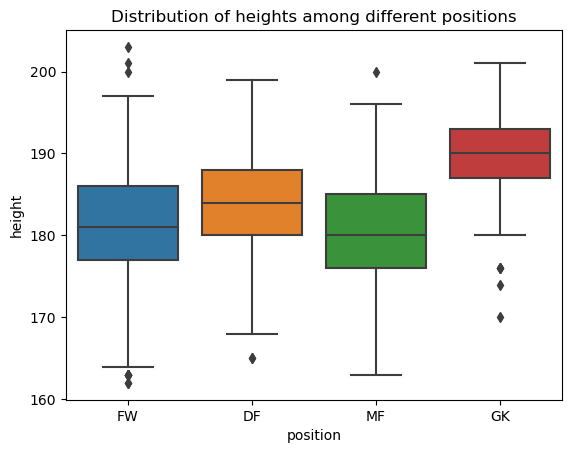

In [5]:
sns.boxplot(data = player_data_exploded, x = 'position', y='height')
plt.title('Distribution of heights among different positions')
plt.show()

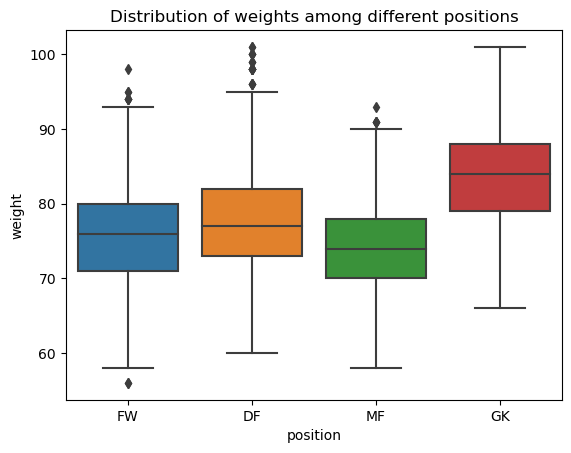

In [6]:
sns.boxplot(data = player_data_exploded, x = 'position', y='weight')
plt.title('Distribution of weights among different positions')
plt.show()